# Group selfie

In [59]:
import pandas as pd
import random
import numpy as np
from sklearn.model_selection import train_test_split
import selfies as sf
import group_selfies as gsf
from rdkit import Chem

random.seed(42)

In [130]:
from upsetplot import UpSet
import matplotlib.pyplot as plt

# Draw fragmentation

In [60]:
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
import rdkit.Chem.Draw as Draw
from rdkit.Chem.Draw import IPythonConsole

from IPython.display import display
from rdkit import RDLogger

RDLogger.DisableLog("rdApp.*")

##from https://sourceforge.net/p/rdkit/mailman/rdkit-discuss/thread/CAHGTkV8sdfb4Q7FLn9C5MTwrqiJjHtnXK%2Bmz2SY3_4j2eAtevQ%40mail.gmail.com/#msg36477772
from rdkit.Chem.Draw import rdMolDraw2D

try:
    import Image
except ImportError:
    from PIL import Image
from io import BytesIO


def DrawMolsZoomed(
    mols, legends, molsPerRow=3, subImgSize=(300, 300)
):  # , leg): #https://www.rdkit.org/docs/source/rdkit.Chem.Draw.rdMolDraw2D.html#rdkit.Chem.Draw.rdMolDraw2D.MolDraw2D
    nRows = len(mols) // molsPerRow
    if len(mols) % molsPerRow:
        nRows += 1
    fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1])
    full_image = Image.new("RGBA", fullSize)
    for ii, mol in enumerate(mols):
        if mol.GetNumConformers() == 0:
            AllChem.Compute2DCoords(mol)
        le = legends[ii]
        column = ii % molsPerRow
        row = ii // molsPerRow
        offset = (column * subImgSize[0], row * subImgSize[1])
        d2d = rdMolDraw2D.MolDraw2DCairo(subImgSize[0], subImgSize[1])
        d2d.DrawMolecule(mol, legend=le)
        d2d.FinishDrawing()
        sub = Image.open(BytesIO(d2d.GetDrawingText()))
        full_image.paste(sub, box=offset)
    return full_image


# Input data

## Extract data from PsychLight file

In [61]:
# import data from PsychLight
PsychLight_data = pd.read_csv(
    "../../data/PsychLight/PsychLight_TrainingSet.csv"
)
print(PsychLight_data.tail())

file_autofragmentation = pd.read_csv("SMILES_PsychLight&all_fingerprint.csv")
print(file_autofragmentation.head())
print(len(file_autofragmentation))

Pyschedelic_drug_43 = pd.read_csv(
    "../../data/ExperimentData/43_Psychedelic_drug_SMILES_Category.csv"
)
print(Pyschedelic_drug_43.head())

    Class  Known              ID  \
49      0  known      ketanserin   
50      0  known      MDL 100907   
51      0  known          prozac   
52      0  known  tabernanthalog   
53      0  known        5-Br-DMT   

                                               SMILES  
49  O=C(c1ccc(F)cc1)C1CCN(CCn2c(=O)[nH]c3ccccc3c2=...  
50      COc1cccc([C@H](O)C2CCN(CCc3ccc(F)cc3)CC2)c1OC  
51                 CNCCC(Oc1ccc(C(F)(F)F)cc1)c1ccccc1  
52                     COc1ccc2c3c([nH]c2c1)CCN(C)CC3  
53                        CN(C)CCc1c[nH]c2ccc(Br)cc12  
          ID                                             SMILES
0       5-HT                         CN(C)CCc1c[nH]c2ccc(O)cc12
1        DMT                            CN(C)CCc1c[nH]c2ccccc12
2  25CN-NBOH                   COc1cc(CCNCc2ccccc2O)c(OC)cc1C#N
3        LSD  CCN(CC)C(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34)C[C@H...
4  N-Me-5-HT                            CNCCc1c[nH]c2ccc(O)cc12
306
         Name                                SMILES    Cate

Add more psychedelic drug info from 43_Psychedelic_drug_SMILES_Category.csv

In [116]:
psy_Pyschedelic_drug_43 = Pyschedelic_drug_43.drop(["Category"], axis=1)
print(psy_Pyschedelic_drug_43.head())

         Name                                SMILES
0        5-HT     C1=CC2=C(C=C1O)C(=CN2)CC(C(=O)O)N
1  4-AcO-MALT  CC(=O)OC1=CC=CC2=C1C(=CN2)CCN(C)CC=C
2   5-MeO-DMT          CN(C)CCC1=CNC2=C1C=C(C=C2)OC
3  5-MeO-DALT    COC1=CC2=C(C=C1)NC=C2CCN(CC=C)CC=C
4  5-MeO-DiPT  CC(C)N(CCC1=CNC2=C1C=C(C=C2)OC)C(C)C


In [70]:
# psy_PsychLight_data.rename(columns={"ID": "Name"}, inplace=True)

# psy_combined_df = pd.concat(
#     [psy_PsychLight_data, psy_Pyschedelic_drug_43], ignore_index=True
# ).drop_duplicates(subset=["Name"])

# print(psy_combined_df)
# # combined_df.to_csv("combined_df.csv", index=False)


               Name                                             SMILES
0              5-ht                         CN(C)CCc1c[nH]c2ccc(O)cc12
1               dmt                            CN(C)CCc1c[nH]c2ccccc12
2         25cn-nboh                   COc1cc(CCNCc2ccccc2O)c(OC)cc1C#N
3               lsd  CCN(CC)C(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34)C[C@H...
4         n-me-5-ht                            CNCCc1c[nH]c2ccc(O)cc12
5        tryptamine                                NCCc1c[nH]c2ccccc12
6         bufotenin                         CN(C)CCc1c[nH]c2ccc(O)cc12
7          psilocin                         CN(C)CCc1c[nH]c2cccc(O)c12
8         5-meo-dmt                        COc1ccc2[nH]cc(CCN(C)C)c2c1
9   n-me-tryptamine                               CNCCc1c[nH]c2ccccc12
10            r-mda                         C[C@@H](N)Cc1ccc2c(c1)OCO2
11              doi                            COc1cc(CC(C)N)c(OC)cc1I
12      noribogaine  CC[C@H]1C[C@@H]2C[C@H]3c4[nH]c5ccc(O)cc5c4CCN(...
13    

## Generate group selfie encoding

### Generate group grammar with all psychedelic fingerprints

In [71]:
# data preparation for fragmenting using X_train
SMILES_autofragmentation = file_autofragmentation["SMILES"].tolist()

print(SMILES_autofragmentation)

['CN(C)CCc1c[nH]c2ccc(O)cc12', 'CN(C)CCc1c[nH]c2ccccc12', 'COc1cc(CCNCc2ccccc2O)c(OC)cc1C#N', 'CCN(CC)C(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34)C[C@H]2N(C)C1', 'CNCCc1c[nH]c2ccc(O)cc12', 'NCCc1c[nH]c2ccccc12', 'CN(C)CCc1c[nH]c2ccc(O)cc12', 'CN(C)CCc1c[nH]c2cccc(O)c12', 'COc1ccc2[nH]cc(CCN(C)C)c2c1', 'CNCCc1c[nH]c2ccccc12', 'C[C@@H](N)Cc1ccc2c(c1)OCO2', 'COc1cc(CC(C)N)c(OC)cc1I', 'CC[C@H]1C[C@@H]2C[C@H]3c4[nH]c5ccc(O)cc5c4CCN(C2)[C@@H]13', 'CC[C@H]1C[C@@H]2C[C@H]3c4[nH]c5ccc(OC)cc5c4CCN(C2)[C@@H]13', 'COc1cc(CCN)c(OC)cc1I', 'CN(C)CCc1c[nH]c2cccc(OP(=O)(O)O)c12', 'CN(C)CCc1c[nH]c2ccc(F)cc12', 'CN(C)CCc1c[nH]c2ccc(Cl)cc12', 'COc1ccc2c(ccn2C[C@@H](C)N(C)C)c1', 'CN(C)CCc1c[nH]c2ccc(Cn3cncn3)cc12', 'CCCN[C@H]1CCc2nc(N)sc2C1', 'CC(=O)NCCc1c[nH]c2ccc(O)cc12', 'c1ccc(C2(N3CCCCC3)CCCCC2)cc1', 'COc1ccc2[nH]cc(CCNC(C)=O)c2c1', 'C#CCN[C@@H]1CCc2ccc(OC(=O)N(C)CC)cc21', 'CCCN(CCC)C1CCc2cccc(O)c2C1', 'C[C@H](N)Cc1ccccc1', 'C[C@H](N)Cc1ccc2c(c1)OCO2', 'C[C@@H](N)Cc1ccccc1', 'O=C(O)Cc1c[nH]c2ccccc12', 'CNC1(c2c

#### default

In [72]:
# generate grammar and dictionary of fragments

# get smiles list from PsychLight data
molecules = [Chem.MolFromSmiles(smiles) for smiles in SMILES_autofragmentation]

# extracting a set of reasonable groups using fragmentation
fragments = gsf.fragment_mols(molecules, method="default")

# create a dictionary of fragments for tracking
vocab_fragment = dict(
    [
        (f"frag{idx}", gsf.Group(f"frag{idx}", frag))
        for idx, frag in enumerate(fragments)
    ]
)

print(fragments)

  0%|          | 0/306 [00:00<?, ?it/s]

100%|██████████| 306/306 [00:06<00:00, 49.49it/s]


['C(C(N(C*1)*1)*1)*1', 'C1=CC2=C3C(=C1)N(*1)C(*1)=C3CC1C2=CC(*1)CN1*1', 'C1=CC2=C3C(=CNC3=C1)CC1C2=CC(*1)CN1*1', 'C1=C2C(=C(*1)C(*1)=C1)C(*1)=CN2*1', 'C1=C2NC(*1)=C(*1)C2=CC(*1)=C1*1', 'C1=CC(*1)=C(*1)C=C1*1', 'C1=C(*1)C2=C(C=C(*1)C(*1)=C2*1)N1*1', 'CC(N)C*1', 'C1=C(*1)C=C(*1)C2=C1OC(*1)(*1)O2', 'C(=C(C(=C(*1)*1)*1)*1)(C(=C(*1)*1)*1)*1']


In [73]:
print(len(fragments))


10


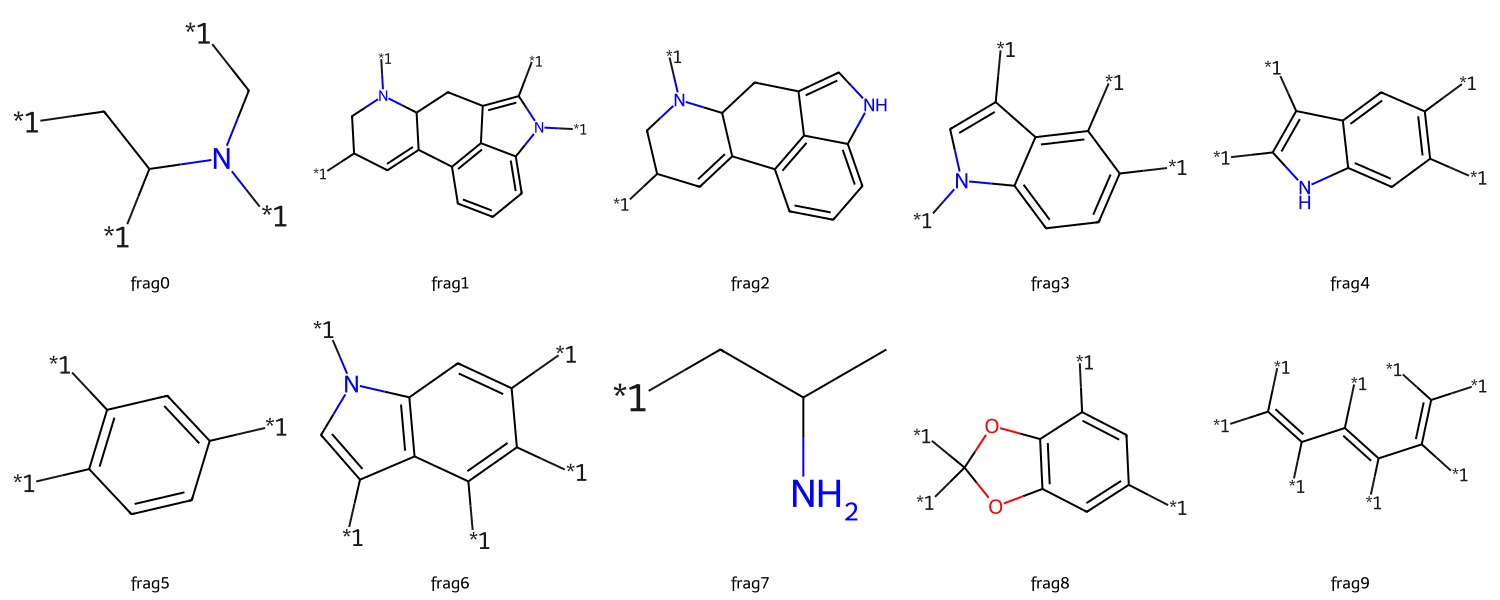

In [74]:
# Ensure the number of legends matches the number of molecules
draw_fragment_default = [g.mol for g in vocab_fragment.values()]
legends_default = [f"frag{idx}" for idx in range(len(molecules))]

display(
    DrawMolsZoomed(
        draw_fragment_default,
        legends=legends_default,molsPerRow=5
    )
)


#### mmpa

In [75]:
# extracting a set of reasonable groups using fragmentation
fragments_mmpa = gsf.fragment_mols(molecules, method="mmpa")

# create a dictionary of fragments for tracking
vocab_fragment_mmpa = dict(
    [(f"frag{idx}", gsf.Group(f"frag{idx}", frag)) for idx, frag in enumerate(fragments_mmpa)]
) 

print(fragments_mmpa)
print(len(fragments_mmpa))

100%|██████████| 306/306 [01:44<00:00,  2.94it/s]


['C(C(*1)*1)(N(C(*1)*1)*1)*1', 'C1=CC2=C3C(=C1)C1=CC(*1)CN(*1)C1CC3=C(*1)N2*1', 'C1=CC2=C3C(=CN2)CC2C(=CC(*1)CN2*1)C3=C1', 'O=C(C1C=C2C3=CC=CC4=C3C(=CN4*1)CC2N(*1)C1)N(CC*1)*1', 'O=C(C1C=C2C3=CC=CC4=C3C(=CN4)CC2N(*1)C1)N(C(C*1)*1)*1', 'COC1=CC(SC(C*1)*1)=C(O*1)C=C1C*1', 'C1=C(CC(*1)*1)C=C(OC*1)C(OC(*1)*1)=C1OC*1', 'COC1=C(*1)C(*1)=C(OC)C(CC(N(C*1)*1)*1)=C1', 'CC(CC1=C(*1)C(*1)=C(*1)C(O*1)=C1)N*1', 'C1=C(*1)C(*1)=C(*1)C2=C1NC(*1)=C2CCN(C(C*1)*1)C(*1)*1', 'COC1=C(C(C(*1)*1)*1)C=C(*1)C(*1)=C1*1', 'COC1=CC(SC(*1)*1)=C(OC)C=C1CC(*1)*1', 'O=C(N(C(*1)*1)*1)*1', 'COC1=CC(*1)=C(*1)C=C1CCNCC1=CC=CC=C1*1', 'COC1=CC(SC(*1)*1)=C(*1)C=C1CC(*1)*1', 'C1=C(CC(*1)*1)C(OC*1)=C(*1)C(*1)=C1*1', 'CC(CC1=CC(O*1)=C(*1)C(*1)=C1*1)N*1', 'COC1=CC=CC=C1CNCCC1=C(*1)C(*1)=C(*1)C(*1)=C1*1', 'COC1=CC(SC(*1)*1)=C(OC)C=C1*1', 'COC1=C(*1)C=C(*1)C(CCNCC2=CC=CC=C2*1)=C1', 'COC1=C(SC(*1)*1)C=C(*1)C(CC(*1)*1)=C1', 'C(N(C(*1)*1)C(*1)*1)(*1)*1', 'COC1=C(*1)C(*1)=C(OC)C(CCNCC2=CC=CC=C2*1)=C1', 'C(OC1=C(OC*1)C(*1)=C(*1)C(*1)=C1

{'frag0': <Group frag0 C(C(*1)*1)(N(C(*1)*1)*1)*1>, 'frag1': <Group frag1 C1=CC2=C3C(=C1)C1=CC(*1)CN(*1)C1CC3=C(*1)N2*1>, 'frag2': <Group frag2 C1=CC2=C3C(=CN2)CC2C(=CC(*1)CN2*1)C3=C1>, 'frag3': <Group frag3 O=C(C1C=C2C3=CC=CC4=C3C(=CN4*1)CC2N(*1)C1)N(CC*1)*1>, 'frag4': <Group frag4 O=C(C1C=C2C3=CC=CC4=C3C(=CN4)CC2N(*1)C1)N(C(C*1)*1)*1>, 'frag5': <Group frag5 COC1=CC(SC(C*1)*1)=C(O*1)C=C1C*1>, 'frag6': <Group frag6 C1=C(CC(*1)*1)C=C(OC*1)C(OC(*1)*1)=C1OC*1>, 'frag7': <Group frag7 COC1=C(*1)C(*1)=C(OC)C(CC(N(C*1)*1)*1)=C1>, 'frag8': <Group frag8 CC(CC1=C(*1)C(*1)=C(*1)C(O*1)=C1)N*1>, 'frag9': <Group frag9 C1=C(*1)C(*1)=C(*1)C2=C1NC(*1)=C2CCN(C(C*1)*1)C(*1)*1>, 'frag10': <Group frag10 COC1=C(C(C(*1)*1)*1)C=C(*1)C(*1)=C1*1>, 'frag11': <Group frag11 COC1=CC(SC(*1)*1)=C(OC)C=C1CC(*1)*1>, 'frag12': <Group frag12 O=C(N(C(*1)*1)*1)*1>, 'frag13': <Group frag13 COC1=CC(*1)=C(*1)C=C1CCNCC1=CC=CC=C1*1>, 'frag14': <Group frag14 COC1=CC(SC(*1)*1)=C(*1)C=C1CC(*1)*1>, 'frag15': <Group frag15 C1=C(CC(*

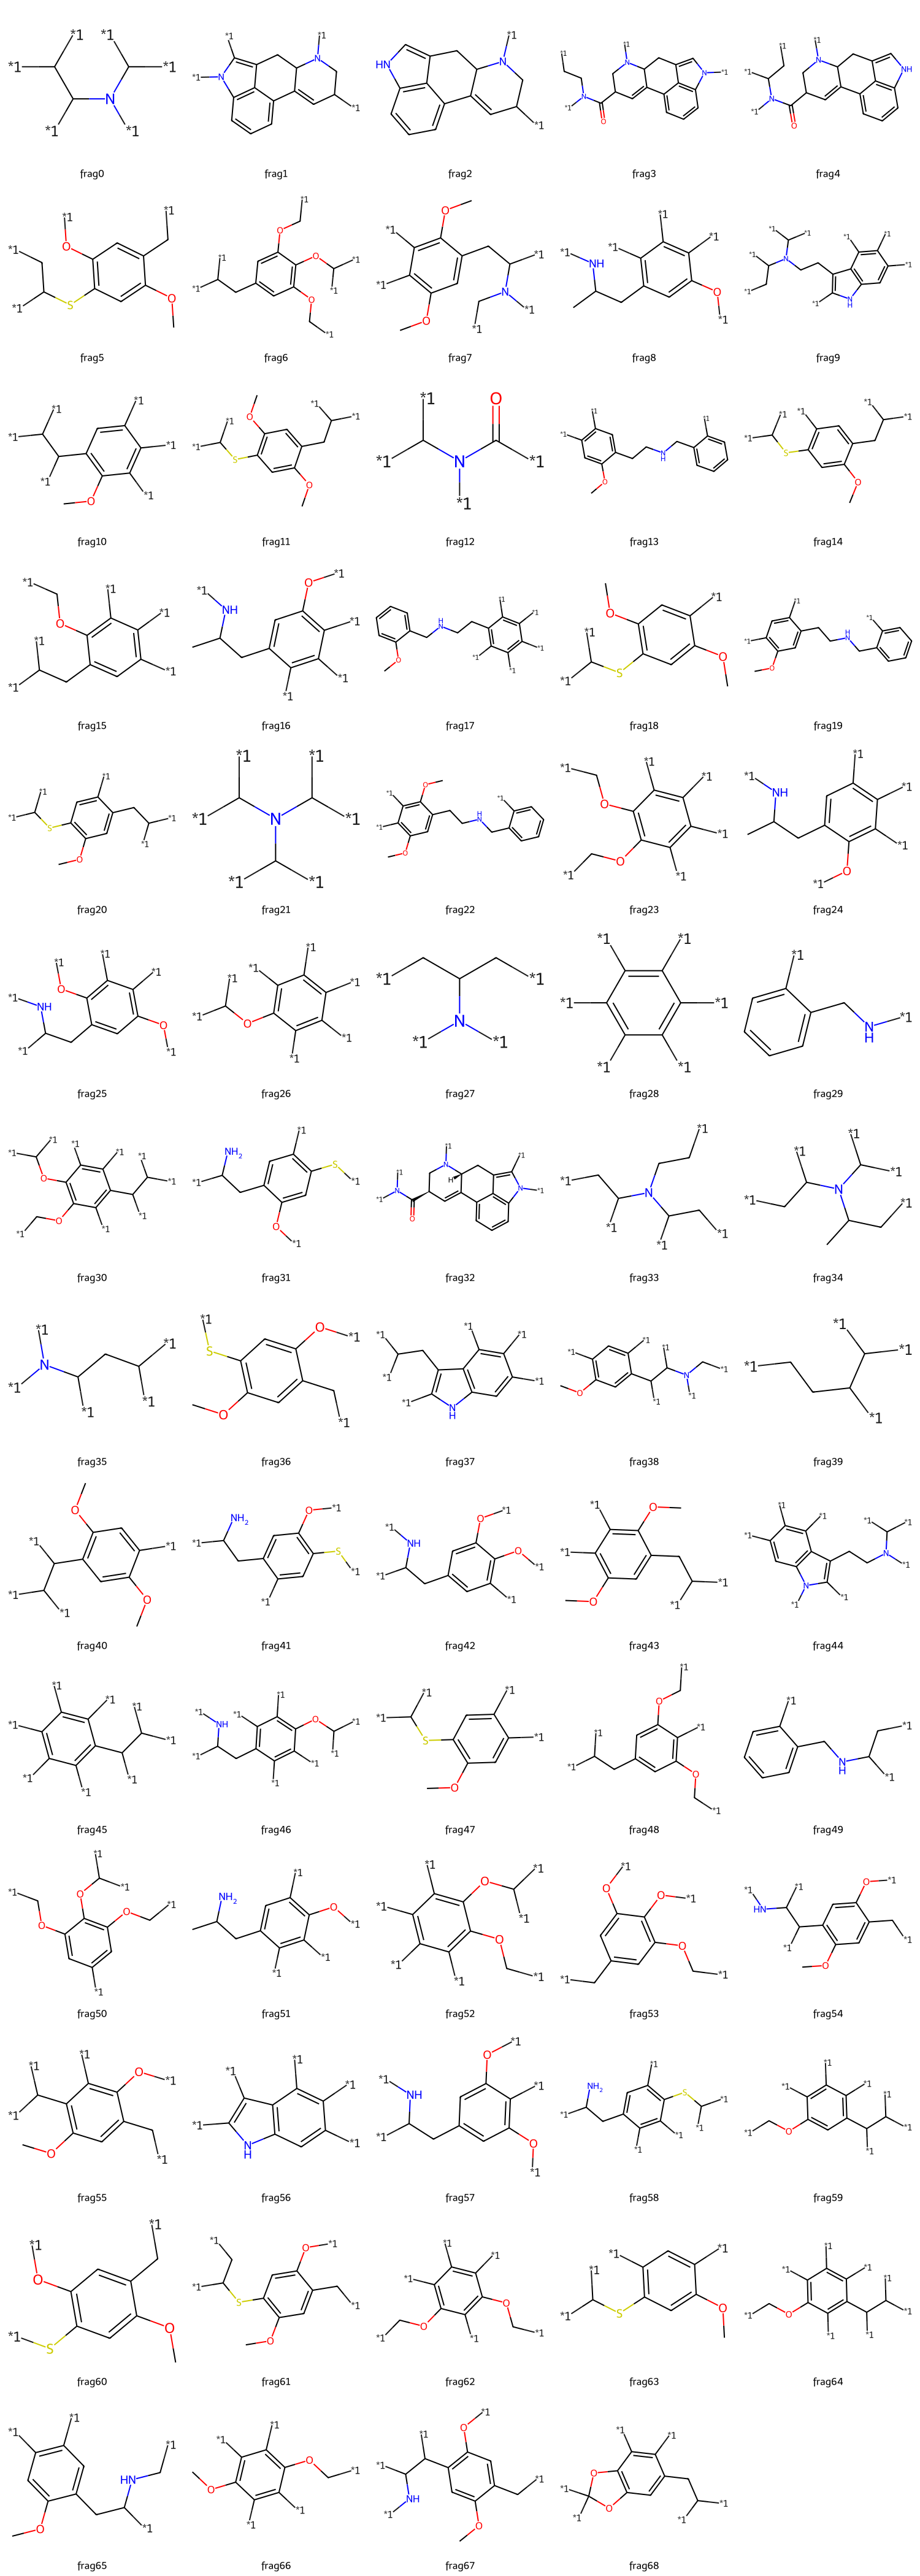

In [76]:
print(vocab_fragment_mmpa)
draw_fragment_mmpa = [f.mol for f in vocab_fragment_mmpa.values()]
print(len(draw_fragment_mmpa)) 
legends_mmpa = [f"frag{idx}" for idx in range(len(draw_fragment_mmpa))]

display(
    DrawMolsZoomed(
        draw_fragment_mmpa,
        legends=legends_mmpa,molsPerRow=5
    )
)


#### fraggle

In [77]:
# extracting a set of reasonable groups using fragmentation
fragments_fraggle = gsf.fragment_mols(molecules, method="fraggle")

# create a dictionary of fragments for tracking
vocab_fragments_fraggle = dict(
    [
        (f"frag{idx}", gsf.Group(f"frag{idx}", frag))
        for idx, frag in enumerate(fragments_fraggle)
    ]
)

print(fragments_fraggle)
print(len(fragments_fraggle))


100%|██████████| 306/306 [00:29<00:00, 10.39it/s]


['C(N(C*1)C(*1)*1)*1', 'COC1=CC=C2C(=C1)C(*1)=C(*1)N2*1', 'COC1=CC=C2NC(*1)=C(*1)C2=C1', 'CN(C)CCC1=CNC(*1)=C1*1', 'C1=CC=C2C(CC*1)=CNC2=C1', 'CCC(C*1)*1', 'CC(N)C*1', 'C1OC(*1)=C(*1)O1', 'COC1=CC(CCN)=C(OC)C=C1*1', 'C(C(N(C*1)*1)*1)*1', 'COC1=CC=CC=C1CN*1', 'C1(*1)=C(*1)C(*1)=C(*1)C(*1)=C1*1', 'COC1=CC(CCN)=CC(OC)=C1*1', 'C1=CC2=C(C(*1)=C1)C(*1)=CN2', 'O=C(C*1)O*1', 'CC(N)CC1=CC(*1)=C(*1)C(*1)=C1', 'CN1CC(C(=O)*1)C=C2C3=CC=CC4=C3C(=CN4)CC21', 'C1=C2NC(*1)=C(*1)C2=C(*1)C(*1)=C1', 'COC1=C(*1)C(*1)=C(*1)C(*1)=C1*1', 'CN1CC(*1)C=C2C3=CC=CC4=C3C(=CN4)CC21', 'C1=C2OCOC2=C(*1)C(*1)=C1']
21


{'frag0': <Group frag0 C(N(C*1)C(*1)*1)*1>, 'frag1': <Group frag1 COC1=CC=C2C(=C1)C(*1)=C(*1)N2*1>, 'frag2': <Group frag2 COC1=CC=C2NC(*1)=C(*1)C2=C1>, 'frag3': <Group frag3 CN(C)CCC1=CNC(*1)=C1*1>, 'frag4': <Group frag4 C1=CC=C2C(CC*1)=CNC2=C1>, 'frag5': <Group frag5 CCC(C*1)*1>, 'frag6': <Group frag6 CC(N)C*1>, 'frag7': <Group frag7 C1OC(*1)=C(*1)O1>, 'frag8': <Group frag8 COC1=CC(CCN)=C(OC)C=C1*1>, 'frag9': <Group frag9 C(C(N(C*1)*1)*1)*1>, 'frag10': <Group frag10 COC1=CC=CC=C1CN*1>, 'frag11': <Group frag11 C1(*1)=C(*1)C(*1)=C(*1)C(*1)=C1*1>, 'frag12': <Group frag12 COC1=CC(CCN)=CC(OC)=C1*1>, 'frag13': <Group frag13 C1=CC2=C(C(*1)=C1)C(*1)=CN2>, 'frag14': <Group frag14 O=C(C*1)O*1>, 'frag15': <Group frag15 CC(N)CC1=CC(*1)=C(*1)C(*1)=C1>, 'frag16': <Group frag16 CN1CC(C(=O)*1)C=C2C3=CC=CC4=C3C(=CN4)CC21>, 'frag17': <Group frag17 C1=C2NC(*1)=C(*1)C2=C(*1)C(*1)=C1>, 'frag18': <Group frag18 COC1=C(*1)C(*1)=C(*1)C(*1)=C1*1>, 'frag19': <Group frag19 CN1CC(*1)C=C2C3=CC=CC4=C3C(=CN4)CC21>, 

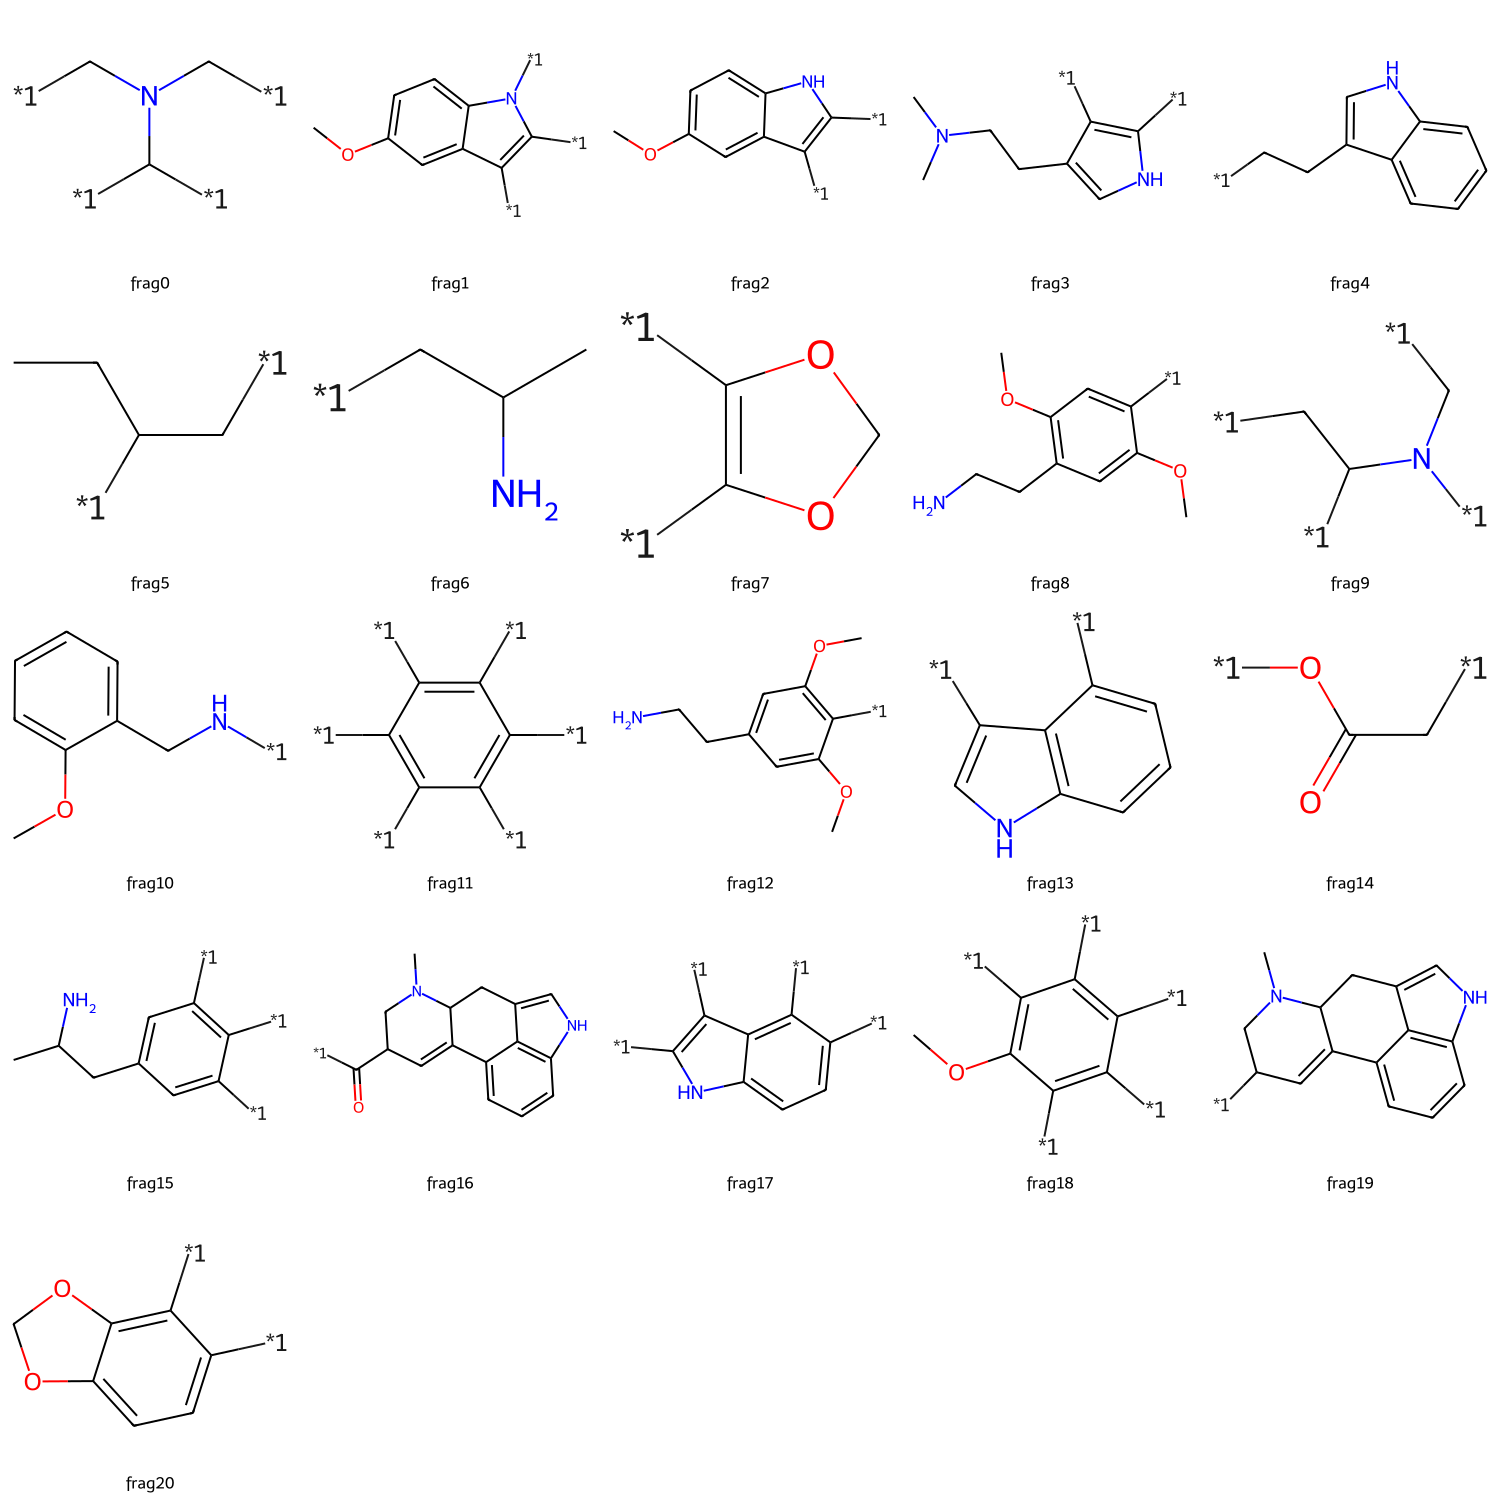

In [78]:
print(vocab_fragments_fraggle)
draw_fragment_fraggle = [f.mol for f in vocab_fragments_fraggle.values()]
print(len(draw_fragment_fraggle))
legends_fraggle = [f"frag{idx}" for idx in range(len(draw_fragment_fraggle))]

display(DrawMolsZoomed(draw_fragment_fraggle, legends=legends_fraggle, molsPerRow=5))


In [79]:
# create a GroupGrammar object using the predefined fragment vocabulary
grammar_auto_default = gsf.GroupGrammar(vocab=vocab_fragment)
grammar_auto_mmpa = gsf.GroupGrammar(vocab=vocab_fragment_mmpa)
grammar_auto_fraggle = gsf.GroupGrammar(vocab=vocab_fragments_fraggle)


# Group selfie encoding for psychedelic drug only

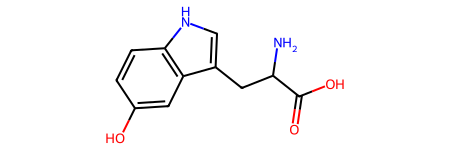

               Name                                             SMILES
0              5-HT                  C1=CC2=C(C=C1O)C(=CN2)CC(C(=O)O)N
1        4-AcO-MALT               CC(=O)OC1=CC=CC2=C1C(=CN2)CCN(C)CC=C
2         5-MeO-DMT                       CN(C)CCC1=CNC2=C1C=C(C=C2)OC
3        5-MeO-DALT                 COC1=CC2=C(C=C1)NC=C2CCN(CC=C)CC=C
4        5-MeO-DiPT               CC(C)N(CCC1=CNC2=C1C=C(C=C2)OC)C(C)C
5        5-MeO-EiPT                  CCN(CCC1=CNC2=C1C=C(C=C2)OC)C(C)C
6           N,N-DMT       CN(C)CCC1=CNC2=CC=CC=C21.C(=C/C(=O)O)\C(=O)O
7          5-OH-DMT                        CN(C)CCC1=CNC2=C1C=C(C=C2)O
8          Psilocin                        CN(C)CCC1=CNC2=C1C(=CC=C2)O
9        Psilocybin               CN(C)CCC1=CNC2=C1C(=CC=C2)OP(=O)(O)O
10          Aleph-1                           COc1cc(SC)c(OC)cc1CC(C)N
11    Allylescaline                        COC1=CC(=CC(=C1OCC=C)OC)CCN
12  Bromo-dragonFLY              C[C@H](CC1=C2C=COC2=C(C3=C1OC=C3)Br)N
13    

In [118]:
# encode for all the psy data
psy_PsychLight_data = psy_PsychLight_data = PsychLight_data[
    PsychLight_data["Class"] == 1
]
# encode_input = [Chem.MolFromSmiles(smiles) for smiles in psy_PsychLight_data["SMILES"]]
encode_input = [
    Chem.MolFromSmiles(smiles) for smiles in psy_Pyschedelic_drug_43["SMILES"]
]
display(encode_input[0])
print(psy_Pyschedelic_drug_43)

## default

In [119]:
group_selfies_default = []
extracted_groups_default = []


for smiles in encode_input:
    encode_mol = grammar_auto_default.full_encoder(smiles)
    group_selfies_default.append(encode_mol)
    extracted = grammar_auto_default.extract_groups(smiles)
    extracted_group = [group.name for group,_,_ in extracted]
    extracted_groups_default.append(extracted_group)

print(extracted_groups_default)
# print(len(group_selfies))

[['frag6'], ['frag6', 'frag0'], ['frag6', 'frag0'], ['frag6', 'frag0'], ['frag6', 'frag0'], ['frag6', 'frag0'], ['frag3', 'frag0'], ['frag6', 'frag0'], ['frag6', 'frag0'], ['frag6', 'frag0'], ['frag7'], [], ['frag9'], [], ['frag5', 'frag5', 'frag0'], ['frag0'], [], [], ['frag0'], ['frag0'], ['frag5', 'frag0'], [], [], [], ['frag0'], ['frag1', 'frag0'], ['frag3', 'frag0', 'frag0'], ['frag1'], ['frag0'], [], ['frag7'], ['frag7'], ['frag1', 'frag0'], ['frag1', 'frag0'], ['frag1', 'frag0'], ['frag1'], ['frag8', 'frag0'], ['frag8', 'frag0'], ['frag3', 'frag0'], ['frag1', 'frag0'], ['frag5'], ['frag5'], ['frag5', 'frag0']]


## mmpa

In [138]:
group_selfie_mmpa = []
extracted_groups_mmpa = []


for smiles in encode_input:
    encode_mol = grammar_auto_mmpa.full_encoder(smiles)
    group_selfie_mmpa.append(encode_mol)
    extracted = grammar_auto_mmpa.extract_groups(smiles)
    extracted_group = [group.name for group, _, _ in extracted]
    extracted_groups_mmpa.append(extracted_group)
    print(extracted_group)

print(extracted_groups_mmpa)

['frag37']
['frag44']
['frag44']
['frag44']
['frag9']
['frag9']
['frag28', 'frag0']
['frag44']
['frag44']
['frag44']
['frag11']
['frag6']
['frag28']
['frag54']
['frag28', 'frag28', 'frag0']
['frag22']
['frag6']
['frag6']
['frag7', 'frag28']
['frag22']
['frag45']
['frag6']
['frag11']
['frag66']
['frag7', 'frag26']
['frag28', 'frag0', 'frag0']
['frag28', 'frag0', 'frag0']
['frag28', 'frag0', 'frag12']
['frag0']
['frag66']
['frag43']
['frag54']
['frag28', 'frag0', 'frag0']
['frag28', 'frag0', 'frag0']
['frag28', 'frag0', 'frag0']
['frag28', 'frag0', 'frag12']
['frag16']
['frag28', 'frag0']
['frag28', 'frag0']
['frag28', 'frag0', 'frag0']
['frag45']
['frag45']
['frag45', 'frag27']
[['frag37'], ['frag44'], ['frag44'], ['frag44'], ['frag9'], ['frag9'], ['frag28', 'frag0'], ['frag44'], ['frag44'], ['frag44'], ['frag11'], ['frag6'], ['frag28'], ['frag54'], ['frag28', 'frag28', 'frag0'], ['frag22'], ['frag6'], ['frag6'], ['frag7', 'frag28'], ['frag22'], ['frag45'], ['frag6'], ['frag11'], ['frag

## fraggle

In [112]:
group_selfies_fraggle = []
extracted_groups_fraggle = []


for smiles in encode_input:
    encode_mol = grammar_auto_fraggle.full_encoder(smiles)
    group_selfies_fraggle.append(encode_mol)
    extracted = grammar_auto_fraggle.extract_groups(smiles)
    extracted_group = [group.name for group, _, _ in extracted]
    extracted_groups_fraggle.append(extracted_group)
    print(extracted_group)

print(extracted_groups_fraggle)


['frag17', 'frag0']
['frag4']
['frag18', 'frag11', 'frag9']
['frag13', 'frag9']
['frag17', 'frag9']
['frag4']
['frag17', 'frag0']
['frag17', 'frag0']
['frag1', 'frag0']
['frag4']
['frag20']
['frag18', 'frag6']
['frag17', 'frag9']
['frag1', 'frag9']
['frag8']
['frag17', 'frag0']
['frag17', 'frag0']
['frag17', 'frag0']
[['frag17', 'frag0'], ['frag4'], ['frag18', 'frag11', 'frag9'], ['frag13', 'frag9'], ['frag17', 'frag9'], ['frag4'], ['frag17', 'frag0'], ['frag17', 'frag0'], ['frag1', 'frag0'], ['frag4'], ['frag20'], ['frag18', 'frag6'], ['frag17', 'frag9'], ['frag1', 'frag9'], ['frag8'], ['frag17', 'frag0'], ['frag17', 'frag0'], ['frag17', 'frag0']]


## Upset Plot for psy

### default

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

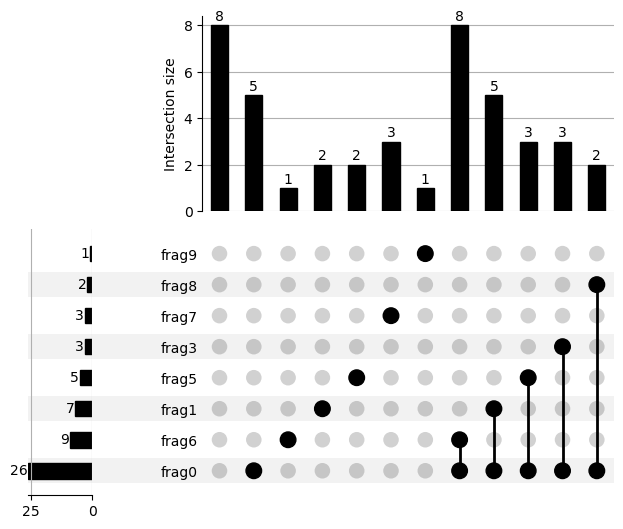

In [131]:
# set the default fragment
all_fragments_default = set(
    fragment for row in extracted_groups_default for fragment in row
)

# create a One-Hot encoded DataFrame
one_hot_df_default = pd.DataFrame(
    0, index=range(len(extracted_groups_default)), columns=sorted(all_fragments_default)
)

# replace the default fragment with occurrence
for i, row in enumerate(extracted_groups_default):
    for fragment in row:
        one_hot_df_default.loc[i, fragment] += 1
        
# count the number of occurrences of each group
one_hot_df_binary = (one_hot_df_default > 0).astype(int)
upset_data_default = (
    one_hot_df_binary.value_counts()
    .reset_index(name="count")
    .groupby(one_hot_df_binary.columns.tolist())["count"]
    .sum()
)

# create an UpSet plot
upset_default = UpSet(upset_data_default, show_counts="%d")
upset_default.plot()


### mmpa

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

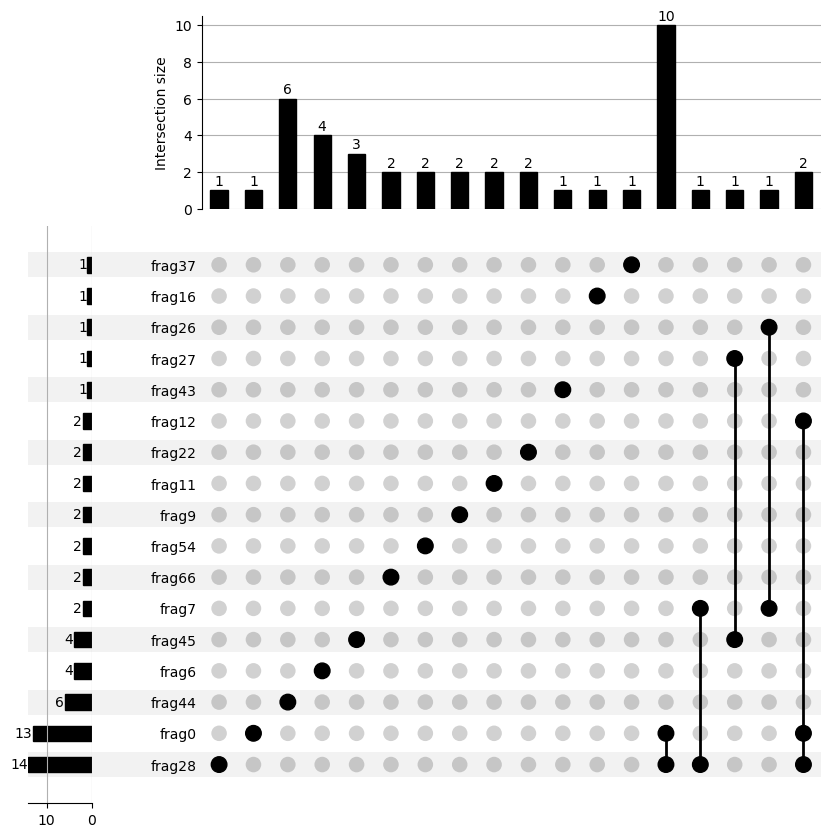

In [142]:
# set the default fragment
all_fragments_mmpa = set(
    fragment for row in extracted_groups_mmpa for fragment in row
)

# create a One-Hot encoded DataFrame
one_hot_df_mmpa = pd.DataFrame(
    0, index=range(len(extracted_groups_mmpa)), columns=sorted(all_fragments_mmpa)
)

# replace the default fragment with occurrence
for i, row in enumerate(extracted_groups_mmpa):
    for fragment in row:
        one_hot_df_mmpa.loc[i, fragment] += 1

# count the number of occurrences of each group
one_hot_df_binary = (one_hot_df_mmpa > 0).astype(int)
upset_data_mmpa = (
    one_hot_df_binary.value_counts()
    .reset_index(name="count")
    .groupby(one_hot_df_binary.columns.tolist())["count"]
    .sum()
)

# create an UpSet plot
upset_mmpa = UpSet(upset_data_mmpa, show_counts="%d")
upset_mmpa.plot()


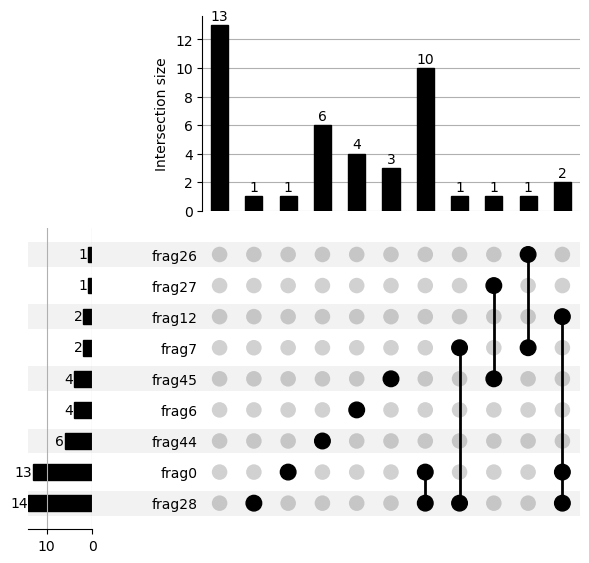

In [143]:
# Step 1: Define the specific fragments you want to analyze
selected_fragments = {
    "frag28",
    "frag0",
    "frag44",
    "frag6",
    "frag45",
    "frag7",
    "frag12",
    "frag27",
    "frag26",
}  # Replace with your desired fragments

# Step 2: Filter the one-hot DataFrame to include only the selected fragments
filtered_fragments = [
    frag for frag in selected_fragments if frag in one_hot_df_mmpa.columns
]
filtered_one_hot_df = one_hot_df_mmpa[filtered_fragments]

# Step 3: Recalculate the binary DataFrame and the UpSet data
filtered_one_hot_df_binary = (filtered_one_hot_df > 0).astype(int)
filtered_upset_data = (
    filtered_one_hot_df_binary.value_counts()
    .reset_index(name="count")
    .groupby(filtered_one_hot_df_binary.columns.tolist())["count"]
    .sum()
)

# Step 4: Generate the UpSet plot for the filtered data
from matplotlib import pyplot as plt
from upsetplot import UpSet

filtered_upset = UpSet(filtered_upset_data, show_counts="%d")
filtered_upset.plot()
plt.show()


### fraggle

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

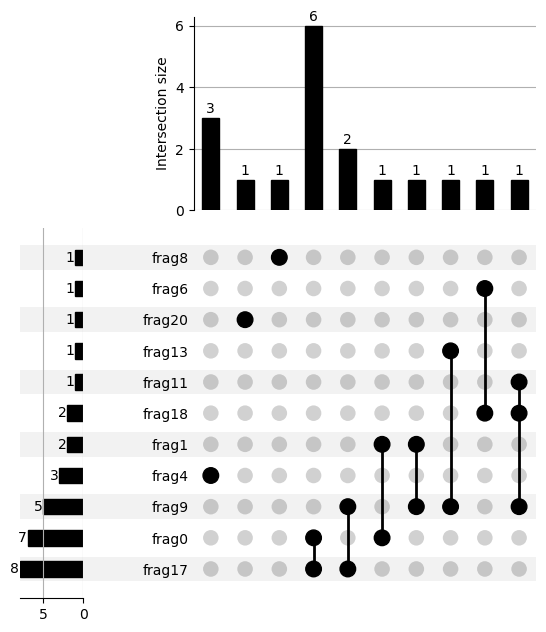

In [141]:
# set the default fragment
all_fragments_fraggle = set(
    fragment for row in extracted_groups_fraggle for fragment in row
)

# create a One-Hot encoded DataFrame
one_hot_df_fraggle = pd.DataFrame(
    0, index=range(len(extracted_groups_fraggle)), columns=sorted(all_fragments_fraggle)
)

# replace the default fragment with occurrence
for i, row in enumerate(extracted_groups_fraggle):
    for fragment in row:
        one_hot_df_fraggle.loc[i, fragment] += 1

# count the number of occurrences of each group
one_hot_df_binary = (one_hot_df_fraggle > 0).astype(int)
upset_data_fraggle = (
    one_hot_df_binary.value_counts()
    .reset_index(name="count")
    .groupby(one_hot_df_binary.columns.tolist())["count"]
    .sum()
)

# create an UpSet plot
upset_fraggle = UpSet(upset_data_fraggle, show_counts="%d")
upset_fraggle.plot()
